In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import time
from multiprocessing import Pool
from matplotlib import ticker

import sys
def rprint(st):
    sys.stdout.write('\r'+str(st))
    sys.stdout.flush()

from breads.utils import broaden, filter_spec_with_spline

In [3]:
cubelist = glob.glob('saved/final/cube_*p.fits')

wavedict = {}
fluxdict = {}
errordict = {}
FSkeys = []
for cfile in cubelist:
    key = cfile.split('.')[-2].split('_')[-1]
    print(key)
    FSkeys.append(key)
    hdulist = fits.open(cfile)
    
    flux = hdulist[0].data[:,30,0]
    err = hdulist[1].data[:,30,0]
    wave = hdulist[4].data

    nanbool = np.logical_not(np.isnan(flux))
    flux = flux[nanbool]
    err = err[nanbool]
    wave = wave[nanbool]
    
    #[Y W/m^2/um] = 2.99792458E+14 * [X1 W/m^2/Hz] / [X2 um]^2
    #1 J y = 1e-26 W/m^2/Hz
    #flux = flux*1e6*1e-26*2.99792458e14/(wave)**2 #MJY -> Jy -> W/m^2/Hz -> W/m^2/um
    #err = err*1e6*1e-26*2.99792458e14/(wave)**2
    
    wavedict[key] = wave
    fluxdict[key] = flux
    errordict[key] = err

a1n1p
a1n2p
a2n1p
a2n2p


In [4]:
hdulist[3].data[30]

array([-0.04449453], dtype='>f8')

In [5]:
node_dict = np.load('fs_uniform_nodes_N136.npy',allow_pickle=True).item()

In [6]:
#atms = np.load('NoCO_CO_atms.npy',allow_pickle=True)
#atms2 = np.load('leave_one_out_atms.npy',allow_pickle=True)
#noch4 = atms2[1]
#atms = atms.tolist()
#atms.append(noch4)

atms = np.load('leave_one_out_atms (7).npy',allow_pickle=True).item()
atms_only = np.load('only_one_molecule_atms.npy',allow_pickle=True).item()
mols = list(atms.keys())
mols

['None',
 'H2O',
 'CH4',
 'CO',
 'NH3',
 'N2',
 'PH3',
 'H2S',
 'TiO',
 'VO',
 'Fe',
 'FeH',
 'CrH',
 'Na',
 'K',
 'Rb',
 'Cs',
 'CO2',
 'HCN',
 'C2H2',
 'C2H4',
 'C2H6',
 'SiO',
 'MgH',
 'OCS',
 'Li',
 'LiOH',
 'LiH',
 'LiCl',
 'LiF']

In [7]:
from breads.atm_utils import miniRGI

mrgi = miniRGI('sonora-elfowl-t', 
               wavelength_bounds=[2.86, 5.14],
               R=2700,
               load_flag = False,
               save_flag = False,
               MJy_flag = True,
               filter_name = 'JWST/NIRCam.F460M'
               )
template_params = [900, 3.5, 0.5, 0.458, 2]
f = mrgi(template_params)[0]

species v0.9.0

Working folder: /user/amadurowicz/51 Eri

Configuration file: /user/amadurowicz/51 Eri/species_config.ini
Database file: /user/amadurowicz/species_database.hdf5
Data folder: /user/amadurowicz/data

Configuration settings:
   - Database: /user/amadurowicz/species_database.hdf5
   - Data folder: /user/amadurowicz/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed
miniRGI model: miniRGI_sonora-elfowl-t_2.86-5.14um_R2700,
parameter bounds: {'teff': (575.0, 1200.0), 'logg': (3.0, 5.5), 'feh': (-1.0, 1.0), 'c_o_ratio': (0.229, 1.145), 'log_kzz': (2.0, 9.0)}
restricting wavelengths: 2.86 to 5.14 um
Spectral Resolution: 2700
Normalizing to 1 MJy in filter : JWST/NIRCam.F460M
broadening... 1/1 


In [8]:
import astropy.units as u
import astropy.constants as const

def Wm2um_2_MJy(w,flam):
    fnu = (flam*u.W/u.m**2/u.micron)/(const.c/(w * u.um)**2)
    f = fnu.to(u.MJy)
    return f.value

atm = atms['None']
wn = atm['wavenumber']
L = np.flip(1/wn*1e4)
flux = np.flip(atm['thermal']*1e-7)

#mjy = Wm2um_2_MJy(L,y)

from species.phot.syn_phot import SyntheticPhotometry
synphot = SyntheticPhotometry('JWST/NIRCam.F460M')
flam = flux*u.W/u.m**2/u.micron
w0 = np.mean(synphot.wavel_range)
fnu = flam * (L * u.um)**2 / const.c
fMJy = fnu.to(u.MJy).value
bandflux, _ = synphot.spectrum_to_flux(L,fMJy.reshape(-1))
normflux = fMJy/bandflux

by = broaden(L,normflux,R=2700)

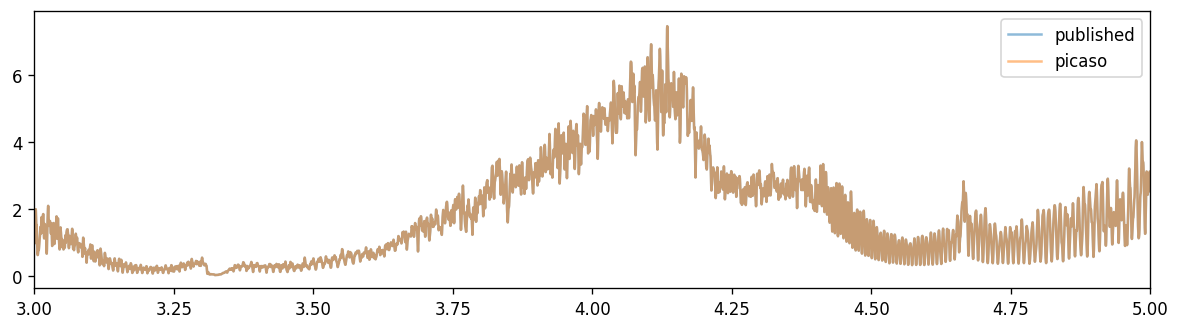

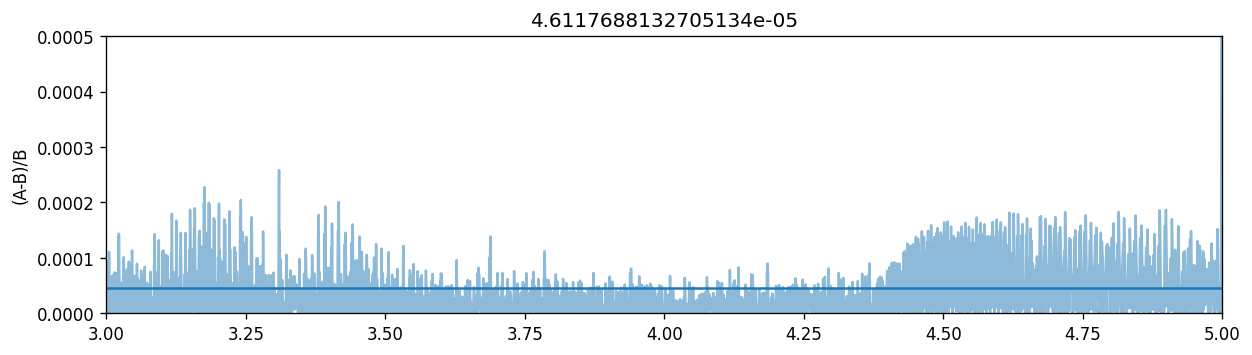

In [9]:
plt.figure(figsize=(12,3),dpi=120)
plt.plot(mrgi.wavelength,f,alpha=0.5)
plt.plot(L,by,alpha=0.5)
plt.xlim([3,5])
#plt.ylim([0,10000])
plt.legend(['published','picaso'])
plt.show()

plt.figure(figsize=(12,3),dpi=120)
interp_ = np.interp(L,mrgi.wavelength,f)
res = abs(interp_-by)/by
mean_err = np.mean(res[abs(L-4)<1])

plt.plot(L,res,alpha=0.5)
plt.axhline(y=mean_err)
plt.xlim([3,5])
plt.ylim([0,5e-4])
plt.ylabel('(A-B)/B')
plt.title(mean_err)
plt.show()



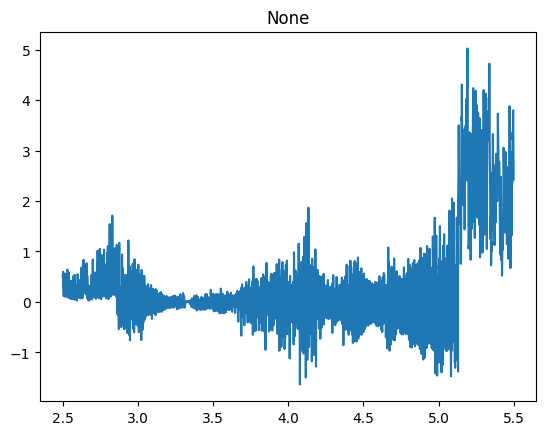

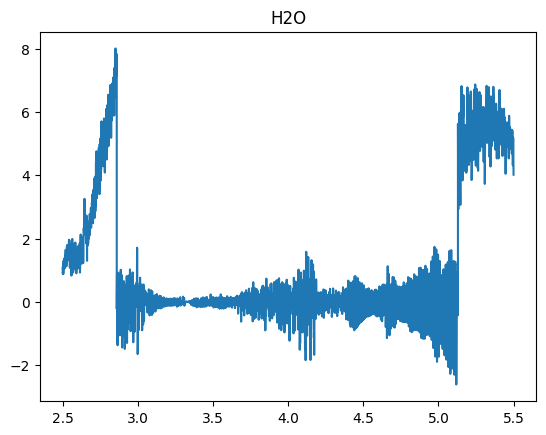

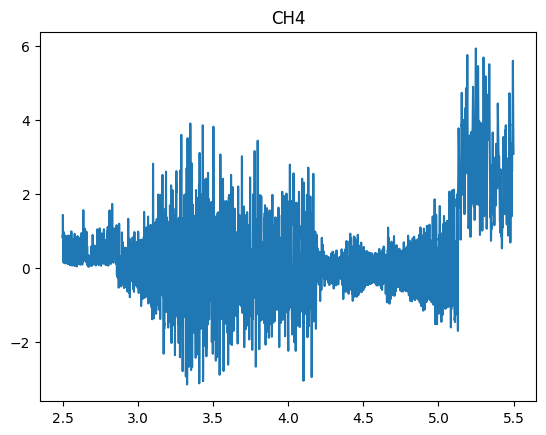

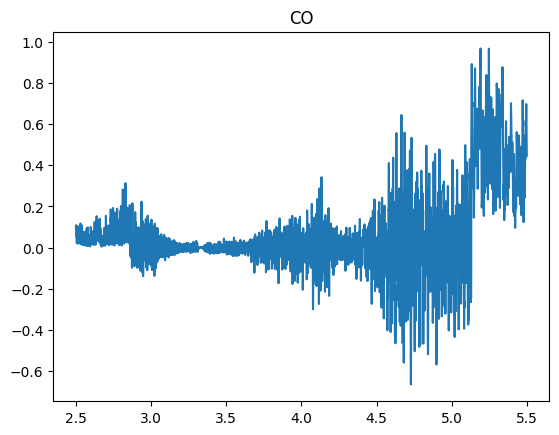

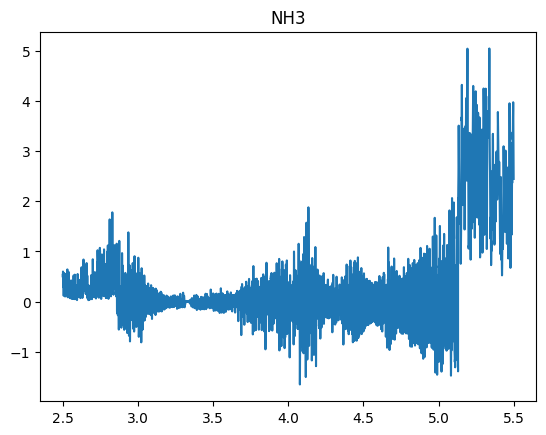

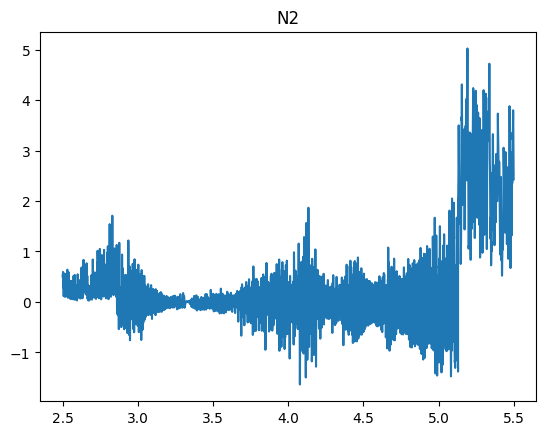

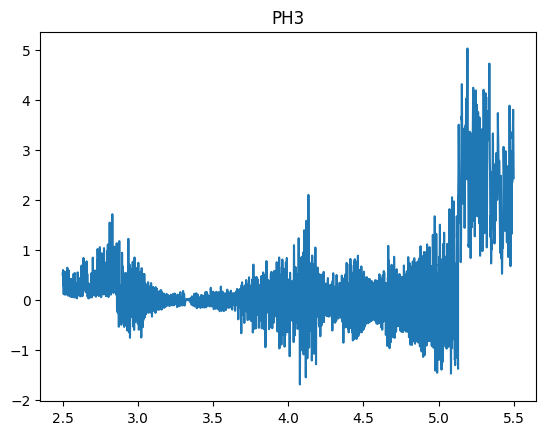

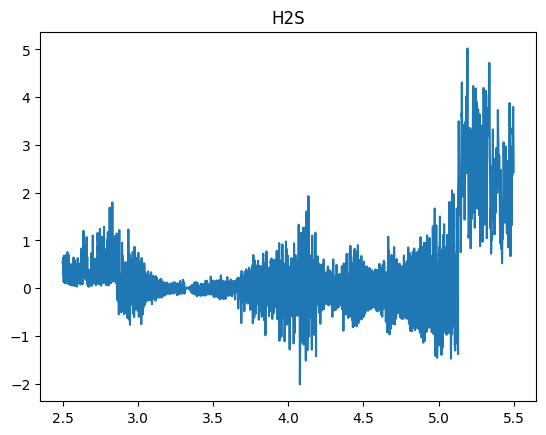

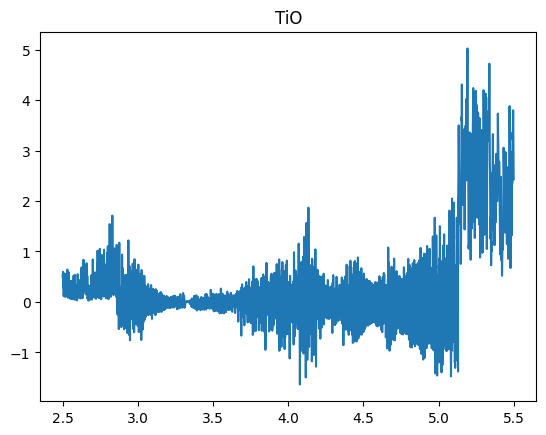

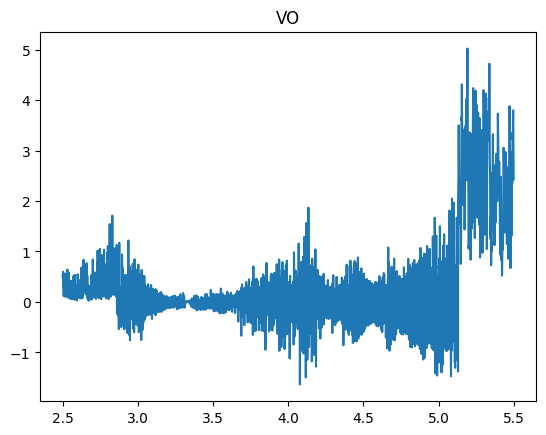

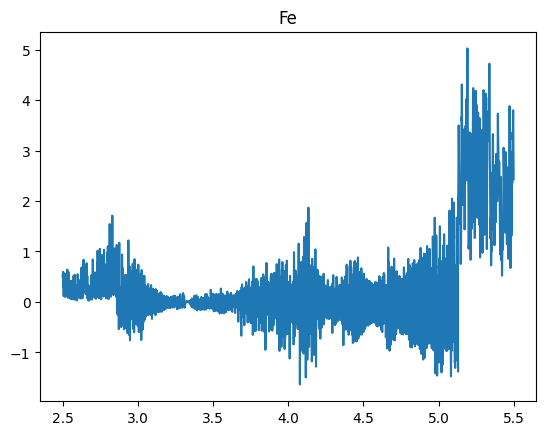

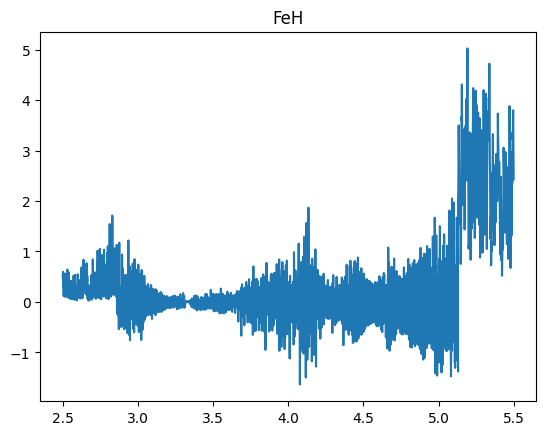

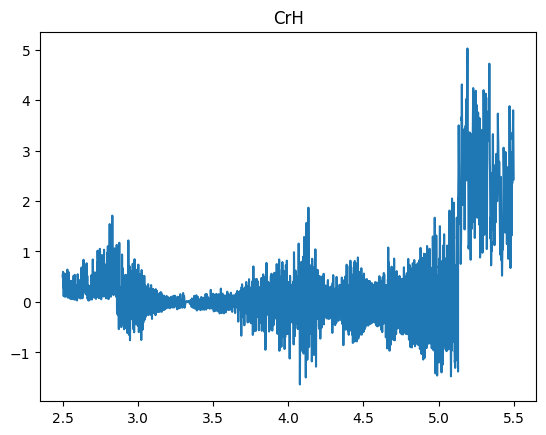

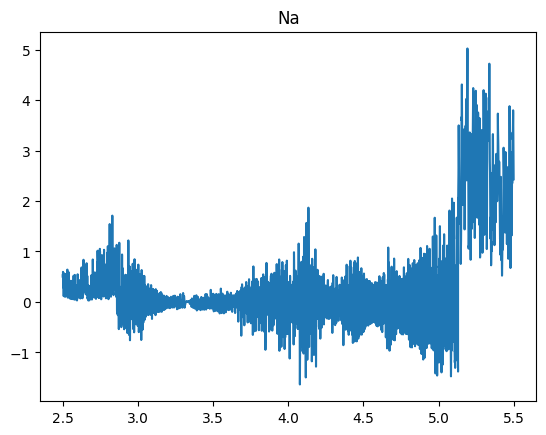

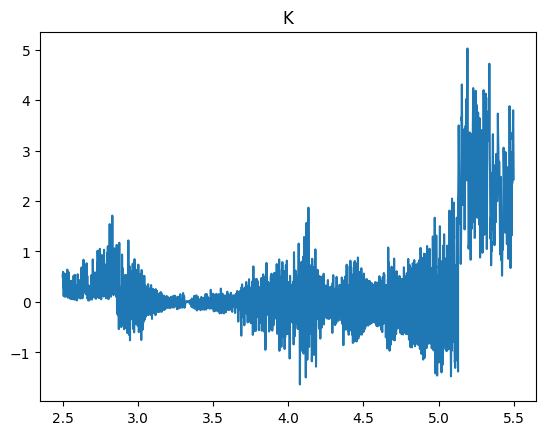

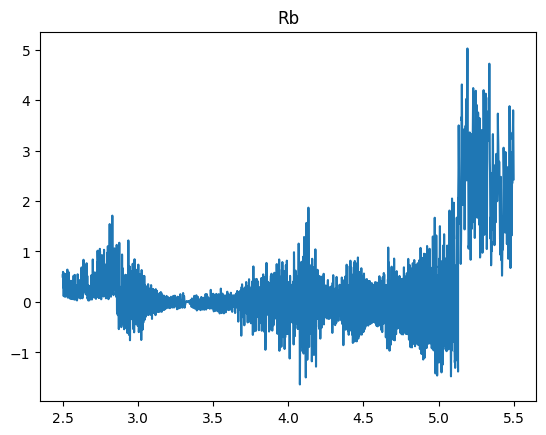

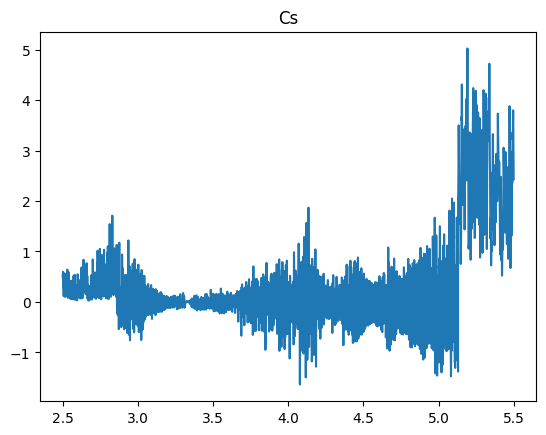

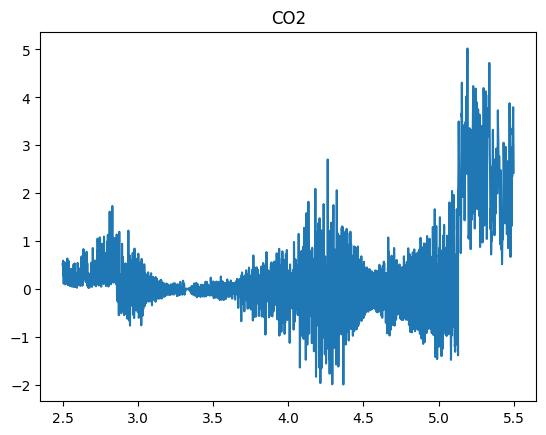

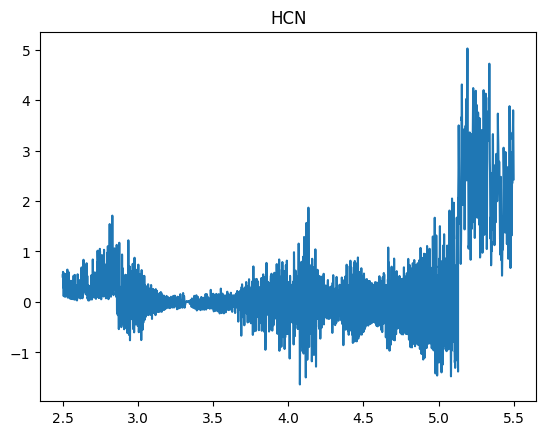

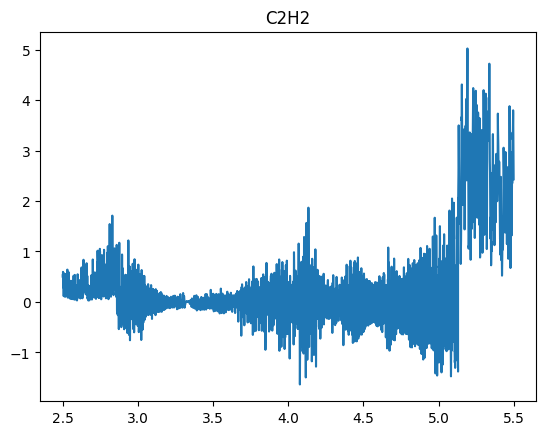

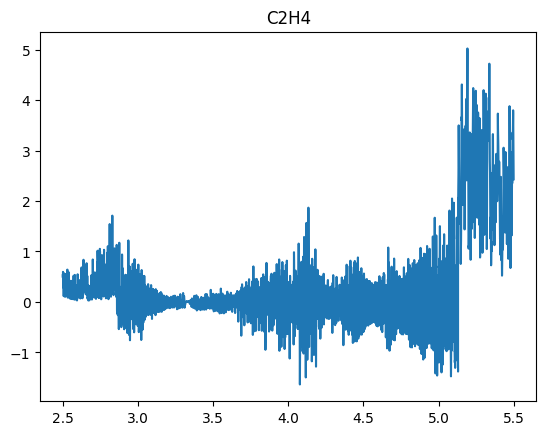

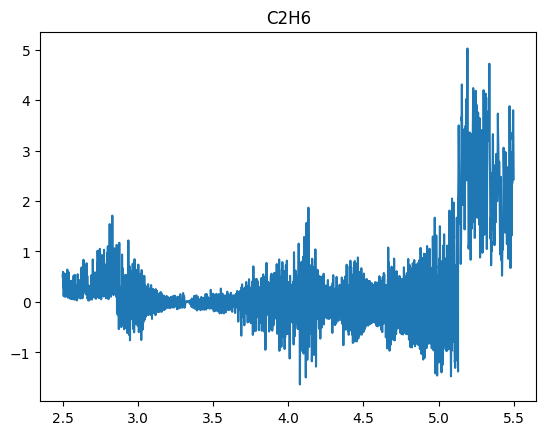

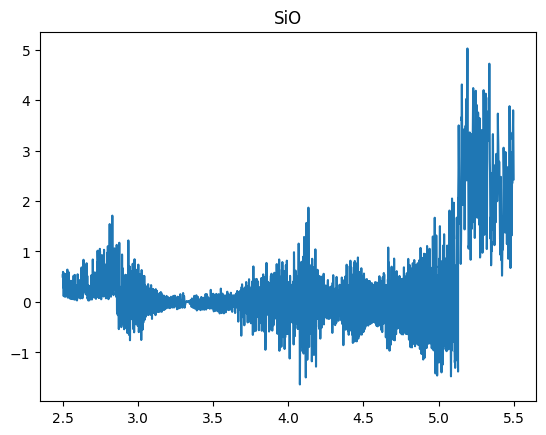

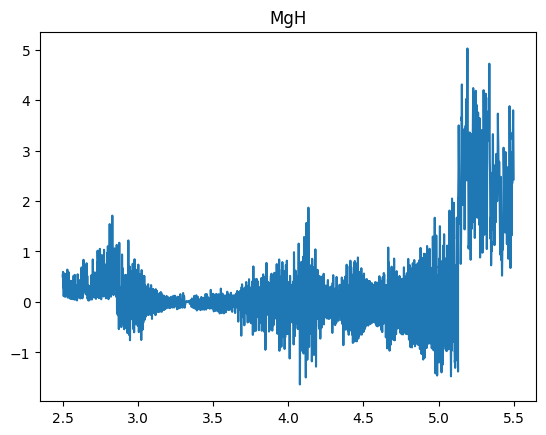

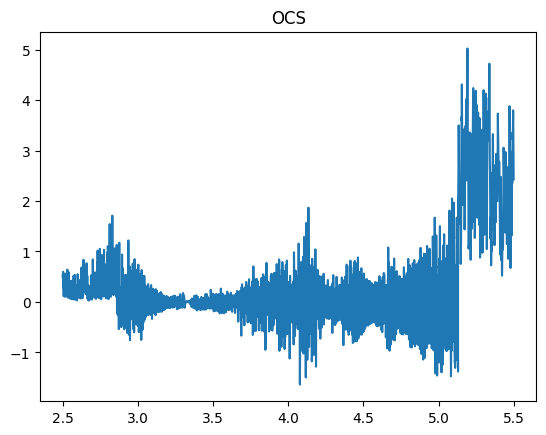

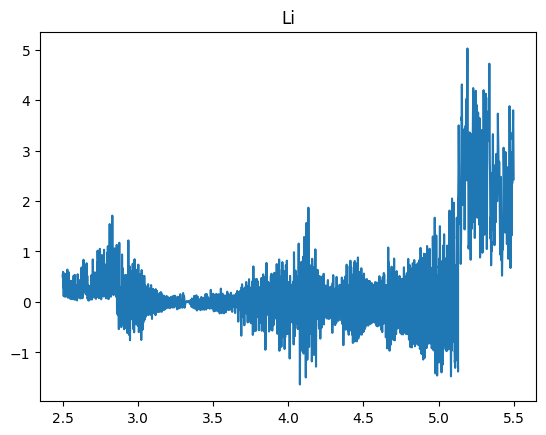

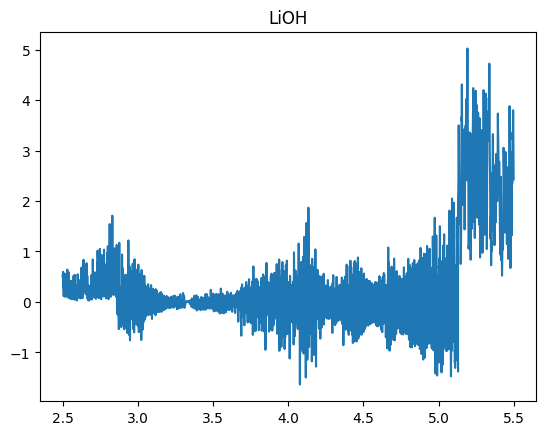

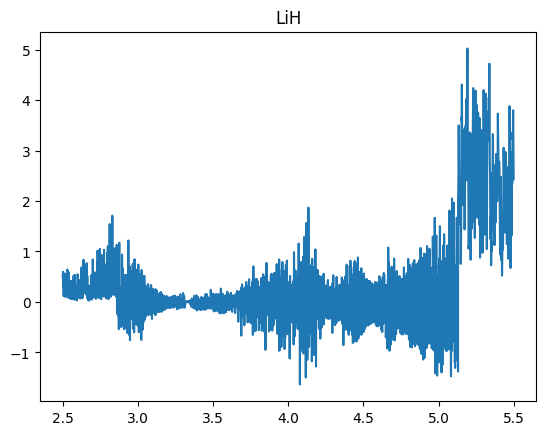

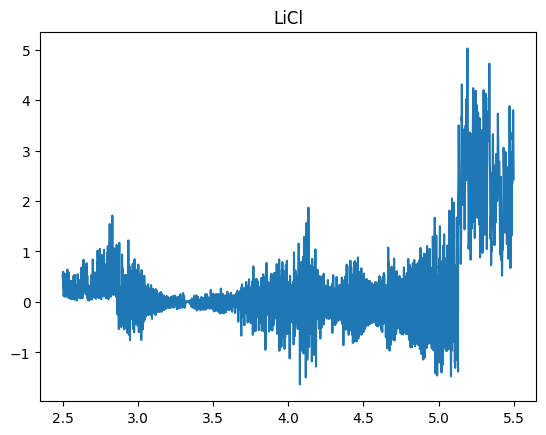

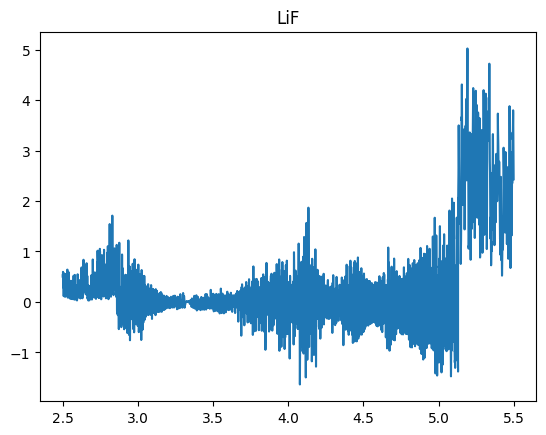

In [10]:

hpf_ys = {}

for mol in mols:
    wn = atms[mol]['wavenumber']
    flux = atms[mol]['thermal']*1e-7
    
    L = 1/wn/100*1e6
    
    nw,xw = 2.5, 5.5 #np.nanmin(wave), np.nanmax(wave)
    wbool = np.logical_and((L>nw),(L<xw))
    L = np.flip(L[wbool])
    flux = np.flip(flux[wbool])

    synphot = SyntheticPhotometry('JWST/NIRCam.F460M')
    flam = flux*u.W/u.m**2/u.micron
    w0 = np.mean(synphot.wavel_range)
    fnu = flam * (L * u.um)**2 / const.c
    fMJy = fnu.to(u.MJy).value
    bandflux, _ = synphot.spectrum_to_flux(L,fMJy.reshape(-1))
    normflux = fMJy/bandflux
    
    by = broaden(L,normflux,R=2700)

    hpf_y,_ = filter_spec_with_spline(L,by,x_nodes=node_dict['all'])

    hpf_ys[mol] = hpf_y
    
    plt.plot(L,hpf_y)
    plt.title(mol)
    plt.show()

In [11]:
all_ccfs = {}
all_ifs = {}
all_ifes = {}
all_stds = {}

for mol in mols:
    
    hpf_y = hpf_ys[mol]

    ccfs = {}
    ifs = {}
    ifes = {}
    stds = {}

    for key in ['a1', 'a2']:
    
        wave = np.concatenate([wavedict[key+'n1p'],wavedict[key+'n2p']])
        flux = np.concatenate([fluxdict[key+'n1p'],fluxdict[key+'n2p']])
        err = np.concatenate([errordict[key+'n1p'],errordict[key+'n2p']])
    
        c = 3e8
        rvs = (np.linspace(-2000,2000,1001))*1e3
    
        cutv = 500e3
        lr = np.where(rvs < -cutv)[0][-1]
        rr = np.where(rvs > cutv)[0][0]

        d = flux
        sig = err
    
        ccf_list = []
        if_list = []
        ife_list = []
        for rv in rvs:
            factor = (1 + rv/c)
            rv_wvs = L*factor
            m = np.interp(wave,rv_wvs,hpf_y)

            iflux = np.nansum(d*m/sig**2)/np.nansum(m*m/sig**2)
            iflux_err = 1/np.sqrt(np.nansum(m*m/sig**2))
            s = iflux/iflux_err
            
            ccf_list.append(s)
            if_list.append(iflux)
            ife_list.append(iflux_err)
            
        std = np.std(np.hstack([np.array(ccf_list)[:lr],np.array(ccf_list)[rr:]]))

        ccfs[key] = np.array(ccf_list)
        ifs[key] = np.array(if_list)
        ifes[key] = np.array(ife_list)
        stds[key] = std

    all_ccfs[mol] = ccfs
    all_ifs[mol] = ifs
    all_ifes[mol] = ifes
    all_stds[mol] = stds

In [12]:
comb_ccfs = {}
comb_sigs = {}

for mol in mols:
    
    f1 = all_ifs[mol]['a1']
    e1 = all_ifes[mol]['a1']
    
    f2 = all_ifs[mol]['a2']
    e2 = all_ifes[mol]['a2']
    
    std1 = all_stds[mol]['a1']
    std2 = all_stds[mol]['a2']
    
    e1 /= std1
    e2 /= std2
    
    cf = (f1/e1**2+f2/e2**2)/(1/e1**2+1/e2**2)
    ce = np.sqrt(1/(1/e1**2+1/e2**2))
    
    ccf = cf/ce
    std = np.std(np.hstack([ccf[:lr],ccf[rr:]]))
    ccf /= std
    
    sig = ccf[500]
    
    comb_ccfs[mol] = ccf
    comb_sigs[mol] = sig

In [13]:
dsigs = {}
for mol in mols:
    dsig = comb_sigs['None']-comb_sigs[mol]
    dsigs[mol] = dsig
    print(mol,np.round(dsig,5))

None 0.0
H2O 0.31829
CH4 3.34685
CO 1.81313
NH3 -0.00093
N2 -0.00075
PH3 0.01563
H2S 0.22328
TiO -0.0
VO -0.0
Fe -0.0
FeH -0.0
CrH -0.0
Na -1e-05
K -0.0
Rb -0.0
Cs -0.0
CO2 0.58117
HCN -0.00338
C2H2 0.0
C2H4 0.0
C2H6 -0.0
SiO 2e-05
MgH 0.0
OCS 0.00016
Li -0.0
LiOH -0.0
LiH -0.0
LiCl -0.0
LiF -0.0


0.0
1.81
0.58
3.35
0.32


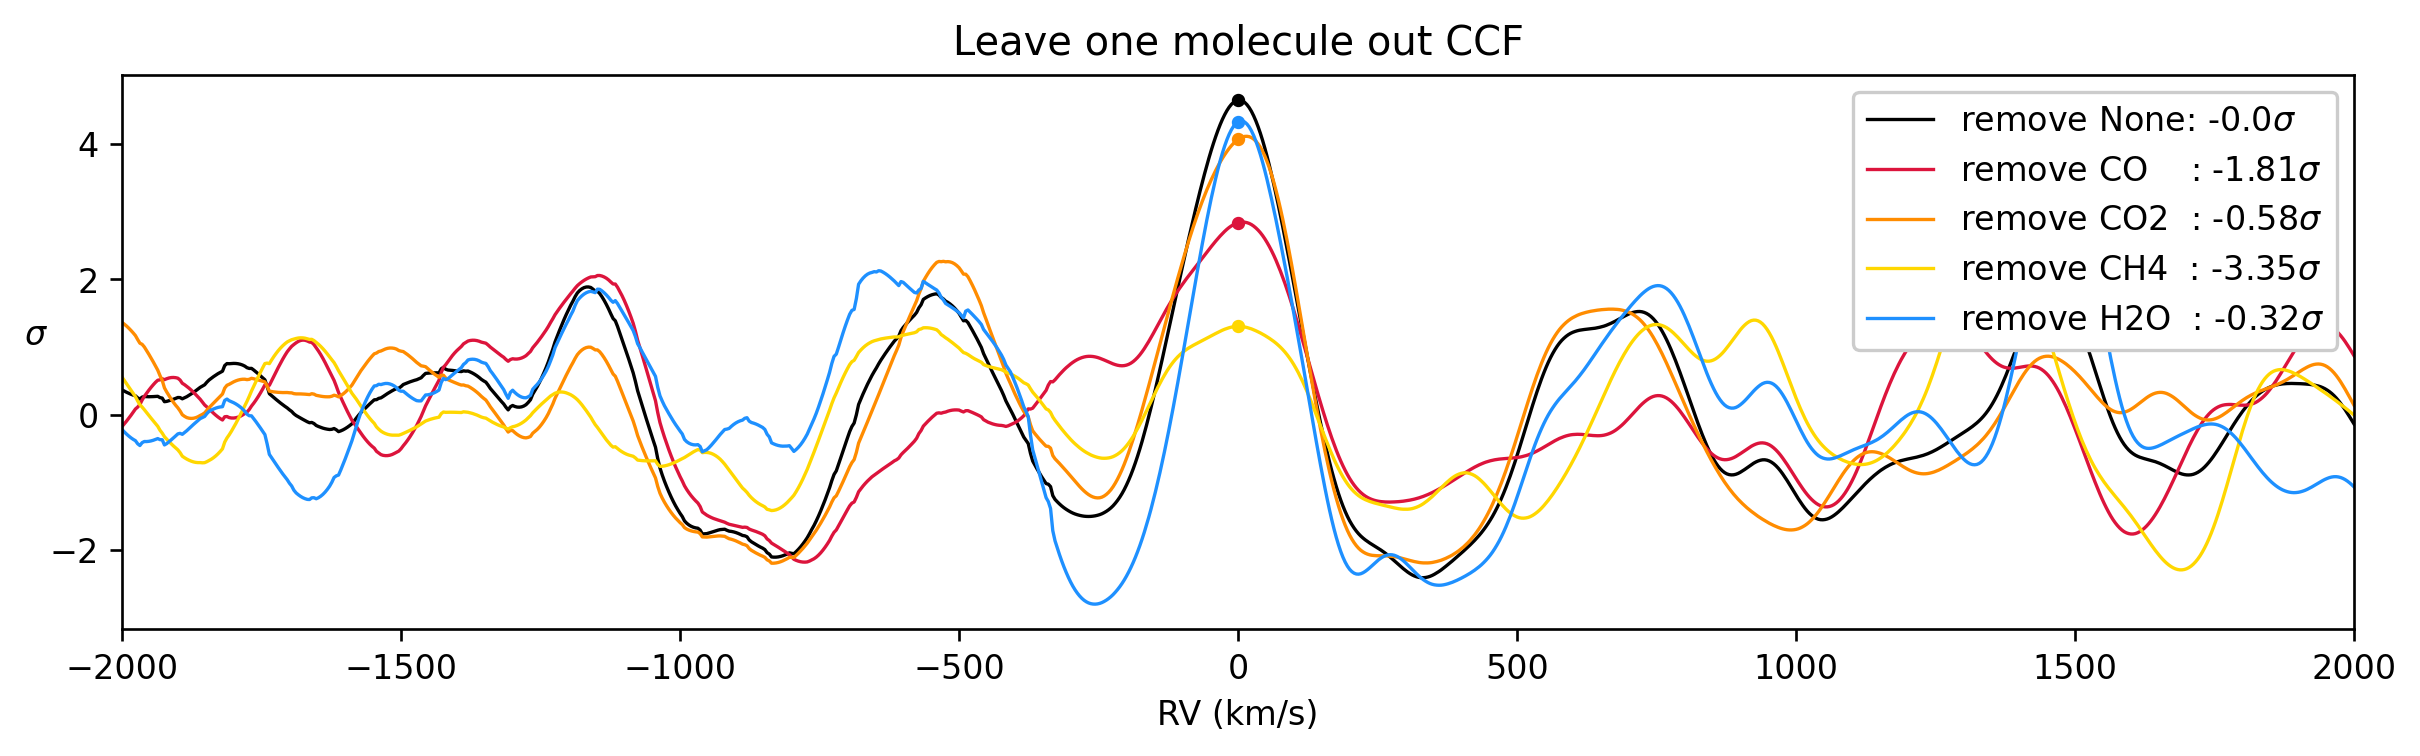

In [14]:
fig,ax = plt.subplots(1,1,figsize=(12,3),dpi=240,sharex=True,sharey=True)

colors = ['black','crimson','darkorange','gold','dodgerblue']
plot_mols = ['None','CO','CO2','CH4','H2O']
spaces = [0, 4, 2, 2, 2]
leg_mols = []
lines = []

for i,mol in enumerate(plot_mols):
    l, = ax.plot(rvs/1000,comb_ccfs[mol],color=colors[i],linewidth=1)
    ax.plot([0],comb_sigs[mol],'.',color=colors[i])
    lines.append(l)
    leg_mols.append('remove '+plot_mols[i]+' '*(spaces[i])+': -'+str(np.round(dsigs[mol],2))+r'$\sigma$')
    print(str(np.round(dsigs[mol],2)))
    
    #ax[0].plot(rvs/1000,all_ccfs[mol]['a1']/all_stds[mol]['a1'],color=colors[i])
    #ax[1].plot(rvs/1000,all_ccfs[mol]['a2']/all_stds[mol]['a2'],color=colors[i])

    #ax[0].plot(rvs[500]/1000,all_ccfs[mol]['a1'][500]/all_stds[mol]['a1'],marker='.',color=colors[i])
    #ax[1].plot(rvs[500]/1000,all_ccfs[mol]['a2'][500]/all_stds[mol]['a2'],marker='.',color=colors[i])

ax.legend(lines,leg_mols,bbox_to_anchor=[1,1,0,0],loc='upper right',framealpha=1)

#ax[0].set_title('a1')
#ax[1].set_title('a2')
ax.set_title('Leave one molecule out CCF')

ax.set_xlabel('RV (km/s)')
ax.set_ylabel(r'$\sigma$',rotation=0)
plt.xlim([-2000,2000])
plt.show()


